<a href="https://colab.research.google.com/github/joaramirezra/Mineral-Border-Dectetion/blob/Documentation/Suavizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b> Extracion de granos usando vision computarizada </b></center>
<center><h3> Bogota 2020 </h3></center>

----

El siguiente notebook tiene como objetivo familiarizar al lector en el impacto que tiene :
 - el cambio de canales de color (RGB, HSI ,HSV ,etc)
 - Las tecnicas de suavizado (con sus respectivos cambio de parametros)
 - procesos morfolgicos (erosiones, aperturas, cierres , etc )
 - operadores de deteccion de bordes (canny, sobel, Laplaciono ) 
 - Tecnicas de umbralizacion 

En el proceso de enmascaramiento (aislamiento) de caracteristicas propias de una escena (imagen). para ello mas que explicar el codigo se crea un notebook interactivo en donde el lector podra ir variando los parametros para observar el impacto que tiene sobre la deteccion de bordes  



In [7]:
#@markdown ---
#@markdown <center><h1><b> Importar librerias </center></h1></b>
#@markdown Este bloque impoorta las librerias necesesarias para el funcionamiento del codigo
#@markdown <br> <ul> <li> tensoflow y keras </li>
#@markdown <li> numpy y pandas </li>
#@markdown <li> algunas otras </li>
#@markdown </ul>

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import cv2
import requests
import io
from matplotlib import pyplot as plt

In [8]:
#@markdown ---
#@markdown <center><h1><b> Cargar Funciones </center></h1></b>
#@markdown Este contiene las funciones usadas en el codigo

#@markdown <br> 
#@markdown <ul> <li> print_images(img) </li>
#@markdown <li> img_color_channel_change(img)</li>
#@markdown <li> countour_draw(img2,real) </li>
#@markdown <li> tresholding(img) </li>
#@markdown </ul>

def print_images(*images):
  subplots = len(images)

  plt.figure(figsize=(15,5))
  for i,img in enumerate(images) :
    plt.subplot(1,subplots,(i+1))
    plt.imshow(img,interpolation='none')
  plt.grid(0)
  plt.show()

def img_color_channel_change(img):  
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # HSV hue-saturation-value
  img_hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  # HSL hue-saturation-lightness
  img_hsL = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
  # YCBCR
  img_YBR = cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB)
  
  return img_hsv,img_hsL,img_YBR,img_gray

def blurring_and_thresholding(img,color, diametro):
  kernel = np.ones((3,3),np.uint8)
  
  meanshift = cv2.pyrMeanShiftFiltering(img,sp=color,sr=diametro)
  
  laplacian = cv2.Laplacian(meanshift,ddepth = cv2.CV_64FC3, ksize=3 )
  laplacian = cv2.convertScaleAbs(laplacian)

  closing = cv2.morphologyEx(laplacian, cv2.MORPH_CLOSE, kernel)
  
  _, binary = cv2.threshold(closing,127,255,cv2.THRESH_BINARY)

  return meanshift,laplacian,binary


def countour_draw(img2,real):
  w, h ,x= real.shape
  original = np.ones((w, h,x ), dtype="uint8")*255
  gray_scale =  cv2.cvtColor( img2 , cv2.COLOR_BGR2GRAY )
  cnts = cv2.findContours(gray_scale, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]

  
  counter = 0
  
  for c in cnts:
    area = cv2.contourArea(c)
    if area > 50:
      counter += 1
      cv2.drawContours(original,[c], 0, ( 200, 0, 128 ), 2)
  
  print("numero de granos encontrados : " , counter)
  original = cv2.addWeighted(real,0.4,original,0.6,0)
  
  return original

def tresholding(img):
  laplacian = cv2.Laplacian(meanshift,ddepth = cv2.CV_64FC3, ksize=3 )
  laplacian = cv2.convertScaleAbs(laplacian)
  laplacian = cv2.cvtColor(laplacian,cv2.COLOR_BGR2GRAY)

  closing = cv2.morphologyEx(laplacian, cv2.MORPH_CLOSE, kernel)
   
  _, binary = cv2.threshold(closing,127,255,cv2.THRESH_BINARY)

  return binary 
  

In [9]:
#@markdown <center> <H1><b> Traer imagenes del repositorio </center> </H1></b>
#@markdown 1. Descargar <br>
#@markdown 2. Descomprimir <br>
#@markdown 2. una vez cargadas la imagenes comentar este bloque

# !wget https://github.com/joaramirezra/Mineral-Border-Dectetion/raw/main/images/minerals.zip
# !unzip minerals.zip

---

# Proceso individual 

 - Tipo de imagen se refiere a alguno de las 3 clases de imagenes 
 - Muestra es el numero de la muestra a selecionar 
 - Canarl se refiere al cambio de canal de la imagen en rgb

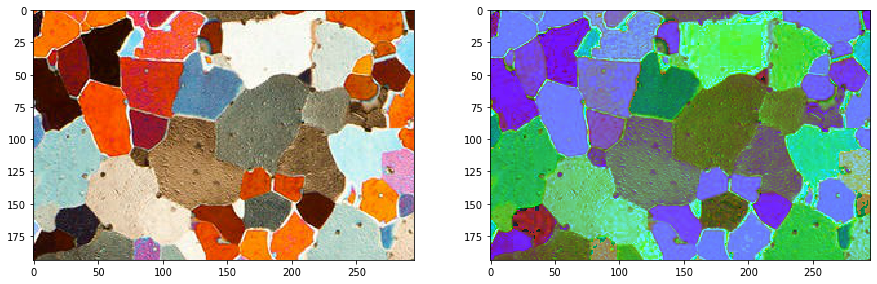

In [10]:
tipo = "3" #@param ["1", "2", "3"]
muestra = 11 #@param {type:"slider", min:1, max:15, step:1}
path = 'type'+tipo+"/Muestra"+str(muestra)+".png"
img = cv2.imread(path)

list_channels = img_color_channel_change(img)
color_channel = [ "hsv", "Hsi","YCBCR"]

canal = "Hsi" #@param [ "hsv", "Hsi","YCBCR"]
index = color_channel.index(canal)
img_to_work = list_channels[index]
print_images(img, list_channels[index])



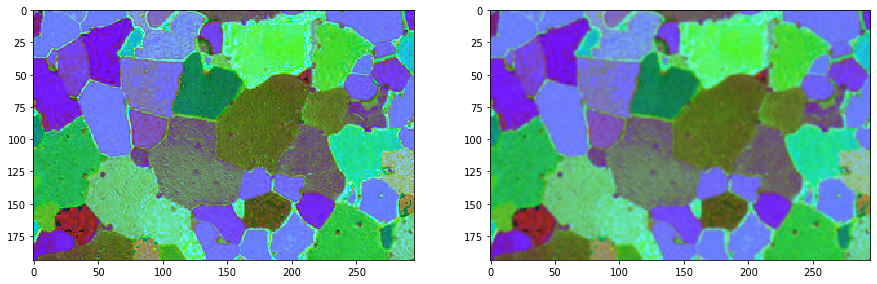

In [11]:
#@markdown ----
#@markdown <h1><b> Filtro Gaussiano
# Filtro Gaussiano 


kernel_size = 3 #@param {type:"slider", min:1, max:7, step:2}
blur_gauss = cv2.GaussianBlur(img_to_work,(kernel_size,kernel_size),0,)
print_images(img_to_work,blur_gauss)

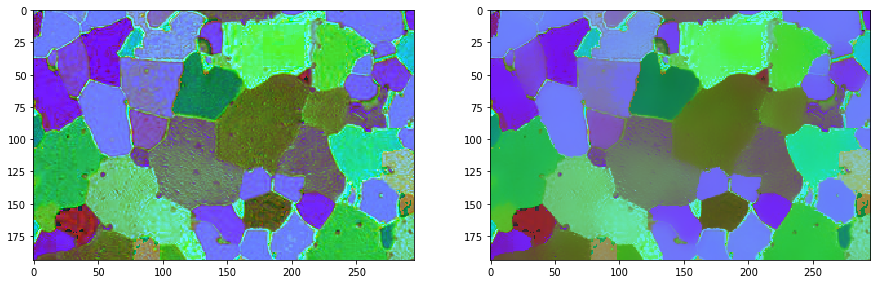

In [20]:
#@markdown ---
#@markdown  # **Parametros filtro bilateral**
 
vecinos =  18#@param {type:"integer"}
sigmaColor =  60#@param {type:"integer"}
sigmaSpace =  60#@param {type:"integer"}

blur_bilateral = cv2.bilateralFilter(img_to_work,vecinos,sigmaColor,sigmaSpace)
print_images(img_to_work,blur_bilateral)


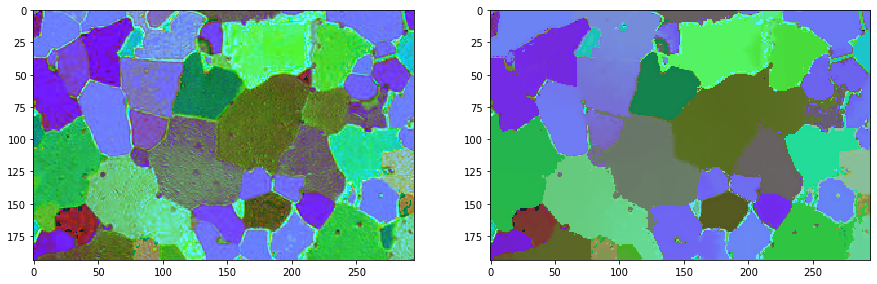

In [21]:
#@markdown ---
#@markdown  # **Parametros Filtro Mean-shift**
 
Rcolor =  27#@param {type:"integer"}
Rdiametro =  56#@param {type:"integer"}

blur_meanshift = cv2.pyrMeanShiftFiltering(img_to_work,sp=Rcolor,sr=Rdiametro)

print_images(img_to_work,blur_meanshift)


# Suavizado variando parametros 
---

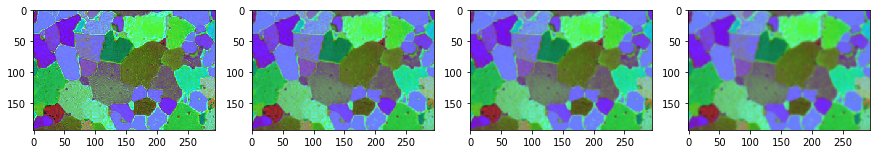

In [14]:
#@markdown # **Evolucion filtro Gaussiano**

kernels = [1,3,5,7]
suavizadas_Gauss = list()

for kernel in kernels :  
  blur = cv2.GaussianBlur(img_to_work,(kernel,kernel),0)
  suavizadas_Gauss.append(blur)

print_images(suavizadas_Gauss[0],suavizadas_Gauss[1],suavizadas_Gauss[2],suavizadas_Gauss[3])


In [15]:
#@markdown #Evolucion filtro meanshift
#@markdown Nota : [(sr_final-sr_inicial)/sr_paso ]%4 ==0

sp_inicial = 60 #@param {type:"slider", min:0, max:100, step:10} 
sp_final = 70 #@param {type:"slider", min:0, max:100, step:10} 
sp_paso = 10 #@param {type:"slider", min:5, max:100, step:5} 


sr_inicial = 60 #@param {type:"slider", min:0, max:100, step:10}
sr_final = 70 #@param {type:"slider", min:0, max:100, step:10}
sr_paso = 5 #@param {type:"slider", min:5, max:100, step:5}

cont = 0
for i in range (sp_inicial,sp_final,sp_paso):
  meanshift_filtro = list()
  for j in range (sr_inicial,sr_final,sr_paso):
      meanshift,laplacian,binary = blurring_and_thresholding(img_to_work,i,j)
      meanshift_filtro.append(meanshift)
      print('sp : ',i,' , sr :', j) 
      cont += 1
      if(cont%4 == 0):
        print_images(meanshift_filtro[0],meanshift_filtro[1],meanshift_filtro[2],meanshift_filtro[3])
        meanshift_filtro = list()
        cont=0

sp :  60  , sr : 60
sp :  60  , sr : 65


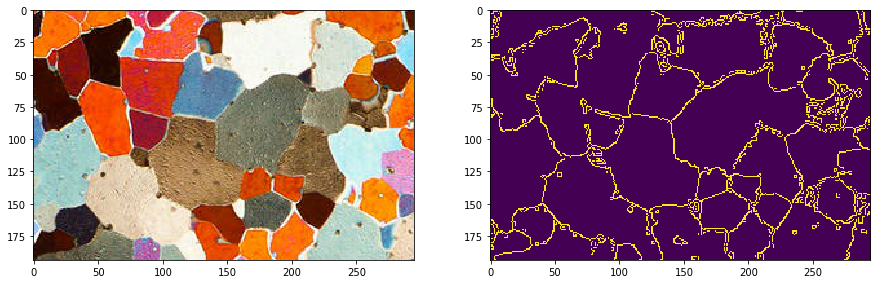

In [29]:
#@markdown ---
#@markdown Extraccion de bordes 
Imagen_a_detectar = "suavizada_meanshift" #@param ["suavizada_guasiana", "suavizada_bilateral", "suavizada_meanshift"]
Histeris_min = 120 #@param {type:"slider", min:0, max:255, step:5} 
Histeris_max = 255 #@param {type:"slider", min:0, max:255, step:5}

index = ["suavizada_guasiana", "suavizada_bilateral"
    , "suavizada_meanshift"].index(Imagen_a_detectar)

list_images = list([blur_gauss,blur_bilateral,blur_meanshift]) 
img2 = list_images[index]

canny = cv2.Canny(img2,Histeris_min,Histeris_max)
print_images(img,canny)




In [30]:
#@title Obtener grano
Grano = 3 #@param {type:"slider", min:0, max:100, step:1}

def obtener_contornos(img):
  cnts = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  finales = []
  for c in cnts:
    area = cv2.contourArea(c)
    if area > 20:
      finales.append(c)
  return finales

def dibujar_contorno(img,contorno):      
  w, h ,x= img.shape
  original = np.ones((w, h,x ), dtype="uint8")*255
  
  cv2.drawContours(original,[contorno], -1, ( 255, 0, 0 ), 2)
  original = cv2.addWeighted(img,0.60,original,0.40,0)
  return original


meanshift,laplacian,binary = blurring_and_thresholding(img,7,20)

contornos = obtener_contornos(laplacian)
print(len(contornos))
print_images(dibujar_contorno(img,contornos[Grano]))


print_images(img,countour_draw(binary,img))

error: ignored

---
---

# Dummy code



In [ ]:
# kernel = np.ones((3,3),np.uint8)
  
# meanshift = cv2.pyrMeanShiftFiltering(img,sp=18,sr=50)

# laplacian = cv2.Laplacian(meanshift,ddepth = cv2.CV_64FC3, ksize=3 )
# laplacian = cv2.convertScaleAbs(laplacian)

# laplacian = cv2.cvtColor(laplacian,cv2.COLOR_BGR2GRAY)
# ret3,th3 = cv2.threshold(laplacian,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# closing = cv2.morphologyEx(th3, cv2.MORPH_CLOSE, kernel)

# _, binary = cv2.threshold(closing,127,255,cv2.THRESH_BINARY)


# print_images(img, meanshift,laplacian,th3)
# print_images(closing,binary)



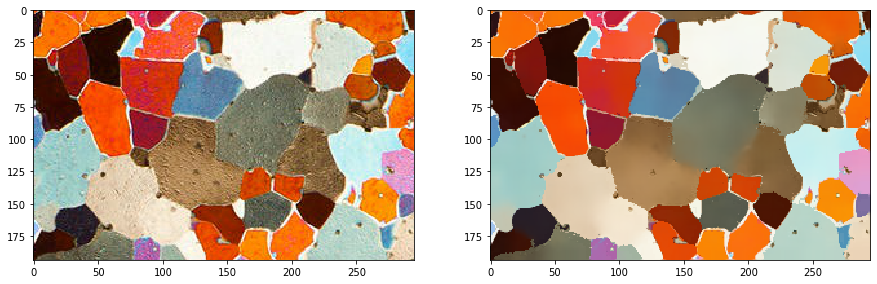

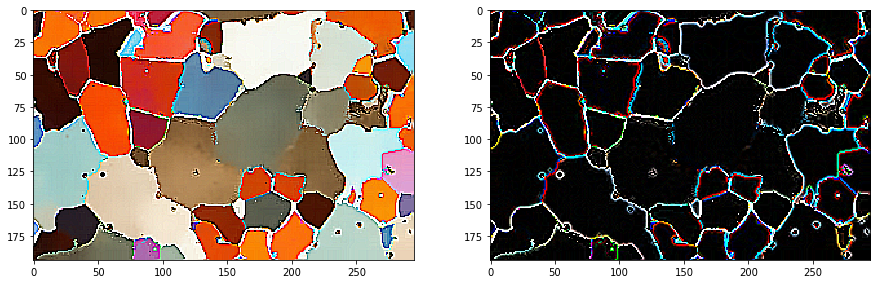

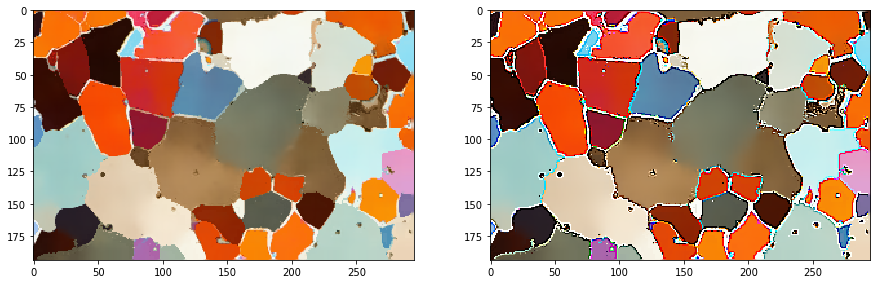

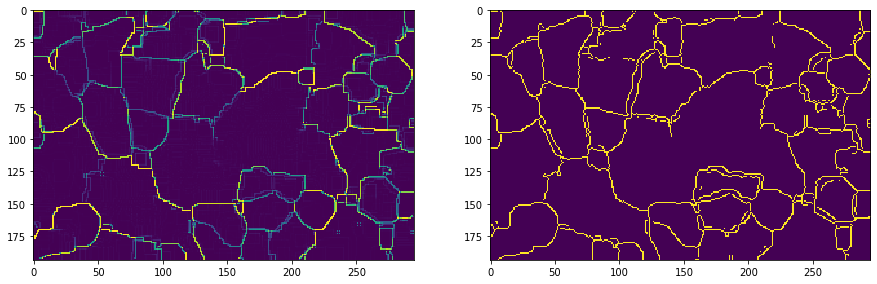

numero de granos encontrados :  32


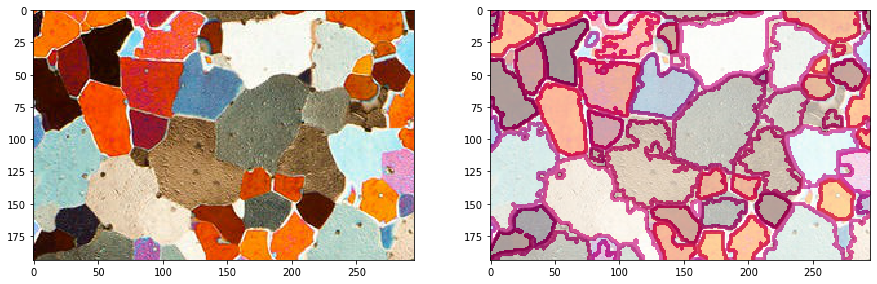

In [33]:

meanshift = cv2.pyrMeanShiftFiltering(img,sp=7,sr=40)

filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
filter2 = np.array([[0,0,-1,0,0],[0,-1,-2,-1,0],[-1,-2,16,-2,-1],[0,-1,-2,-1,0],[0,0,-1,0,0]])

# Applying cv2.filter2D function on our Cybertruck image
sharpen_img_1=cv2.filter2D(meanshift,-1,filter)
sharpen_img_2=cv2.filter2D(meanshift,-1,filter2)

meanshift2 = cv2.pyrMeanShiftFiltering(sharpen_img_1,sp=7,sr=40)


kernel = np.ones((5,5),np.uint8)
closing = cv2.morphologyEx(meanshift2, cv2.MORPH_CLOSE, kernel)
kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(closing,kernel,iterations = 2)


canny = cv2.Canny(erosion,150,200)
laplacian = cv2.Laplacian(erosion,ddepth = cv2.CV_8U, ksize=3 )
laplacian = cv2.convertScaleAbs(laplacian)
laplacian = cv2.cvtColor(laplacian,cv2.COLOR_BGR2GRAY)
print_images(img,meanshift)
print_images(sharpen_img_1,sharpen_img_2)
print_images(meanshift,meanshift2)
print_images(laplacian,canny)



meanshift,laplacian,binary = blurring_and_thresholding(img,7,20)
print_images(img,countour_draw(binary,img))

In [ ]:
# import cv2
# import numpy as np
# from skimage.feature import peak_local_max
# from skimage.morphology import watershed
# from scipy import ndimage

# image = img.copy()
# gray = cv2.cvtColor(meanshift,cv2.COLOR_BGR2GRAY)
# canny = cv2.Canny(gray,150,255)
# thresh = cv2.threshold(canny, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# distance_map = ndimage.distance_transform_edt(thresh)
# local_max = peak_local_max(distance_map, indices=False, min_distance=20, labels=thresh)

# # Perform connected component analysis then apply Watershed
# markers = ndimage.label(local_max, structure=np.ones((3, 3)))[0]
# labels = watershed(-distance_map, markers, mask=thresh)

# # Iterate through unique labels
# total_area = 0
# for label in np.unique(labels):
#     if label == 0:
#         continue

#     # Create a mask
#     mask = np.zeros(gray.shape, dtype="uint8")
#     mask[labels == label] = 255

#     # Find contours and determine contour area
#     cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     cnts = cnts[0] if len(cnts) == 2 else cnts[1]
#     c = max(cnts, key=cv2.contourArea)
#     area = cv2.contourArea(c)
#     total_area += area
#     cv2.drawContours(image, [c], -1, (50,255,12), 1)

# print_images(img,image)
